# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

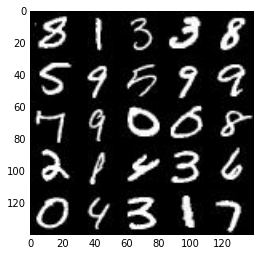

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

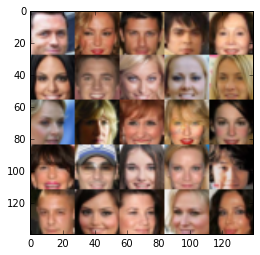

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(dtype=tf.float32, shape=[None, image_width, image_height, image_channels], name="input_img")
    input_z = tf.placeholder(dtype=tf.float32, shape=[None, z_dim], name="input_z")
    learning_rate = tf.placeholder(dtype=tf.float32, name="learning_rate")
    return input_img, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        # image: 28*28*3
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(alpha*conv1, conv1)
        # size: 14*14*64
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', activation=None)
        batch2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha*batch2, batch2)
        # size: 7*7*128
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        batch3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha*batch3, batch3)
        # size: 4*4*256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512, activation=None)
        img1 = tf.reshape(x1, (-1,7,7,512))
        batch1 = tf.layers.batch_normalization(img1, training=is_train)
        relu1 = tf.maximum(batch1*alpha, batch1)
        # size: 7*7*512
        
        img2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', activation=None)
        batch2 = tf.layers.batch_normalization(img2, training=is_train)
        relu2 = tf.maximum(batch2*alpha, batch2)
        # size: 14*14*256
        
        img3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', activation=None)
        batch3 = tf.layers.batch_normalization(img3, training=is_train)
        relu3 = tf.maximum(batch3*alpha, batch3)
        # size: 28*28*128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        out = tf.tanh(logits)
        # size: 28*28*out_channel_dim
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logit_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_logit_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_logit_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_logit_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [x for x in t_vars if x.name.startswith("discriminator")]
    g_vars = [x for x in t_vars if x.name.startswith("generator")]
    
    d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.1):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    real_image, z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_image, z, data_shape[3], alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_image: batch_images, z: batch_z})
                _ = sess.run(g_opt, feed_dict={z: batch_z})
                
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({real_image: batch_images, z: batch_z})
                    train_loss_g = g_loss.eval({z: batch_z})
                    
                    print("Epoch {}/{}\t".format(epoch_i, epoch_count),
                          "Discirminator Loss {:.4f}\t".format(train_loss_d),
                          "Generator Loss {:.4f}".format(train_loss_g))
                
                if step % 100 == 0:
                    show_generator_output(sess, 25, z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2	 Discirminator Loss 1.9357	 Generator Loss 0.4454
Epoch 0/2	 Discirminator Loss 1.5582	 Generator Loss 0.5661
Epoch 0/2	 Discirminator Loss 1.3702	 Generator Loss 0.6463
Epoch 0/2	 Discirminator Loss 1.4019	 Generator Loss 0.6115
Epoch 0/2	 Discirminator Loss 1.4116	 Generator Loss 0.5959
Epoch 0/2	 Discirminator Loss 1.3489	 Generator Loss 0.6591
Epoch 0/2	 Discirminator Loss 1.2965	 Generator Loss 0.7038
Epoch 0/2	 Discirminator Loss 1.1877	 Generator Loss 0.7613
Epoch 0/2	 Discirminator Loss 1.1168	 Generator Loss 0.8564
Epoch 0/2	 Discirminator Loss 1.0936	 Generator Loss 0.9084


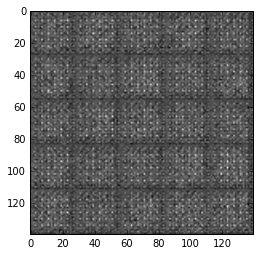

Epoch 0/2	 Discirminator Loss 1.0320	 Generator Loss 0.9629
Epoch 0/2	 Discirminator Loss 1.0424	 Generator Loss 1.0084
Epoch 0/2	 Discirminator Loss 1.0600	 Generator Loss 0.9675
Epoch 0/2	 Discirminator Loss 1.5256	 Generator Loss 0.6268
Epoch 0/2	 Discirminator Loss 1.3555	 Generator Loss 0.7834
Epoch 0/2	 Discirminator Loss 1.4093	 Generator Loss 0.7585
Epoch 0/2	 Discirminator Loss 1.3819	 Generator Loss 0.7990
Epoch 0/2	 Discirminator Loss 1.3086	 Generator Loss 0.8704
Epoch 0/2	 Discirminator Loss 1.3374	 Generator Loss 0.8576
Epoch 0/2	 Discirminator Loss 1.3983	 Generator Loss 0.8414


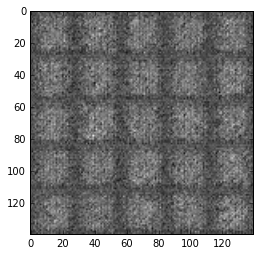

Epoch 0/2	 Discirminator Loss 1.4427	 Generator Loss 0.8417
Epoch 0/2	 Discirminator Loss 1.5202	 Generator Loss 0.8543
Epoch 0/2	 Discirminator Loss 1.5058	 Generator Loss 0.8153
Epoch 1/2	 Discirminator Loss 1.5127	 Generator Loss 0.8576
Epoch 1/2	 Discirminator Loss 1.4440	 Generator Loss 0.8663
Epoch 1/2	 Discirminator Loss 1.5362	 Generator Loss 0.8299
Epoch 1/2	 Discirminator Loss 1.4288	 Generator Loss 0.8705
Epoch 1/2	 Discirminator Loss 1.3685	 Generator Loss 0.9049
Epoch 1/2	 Discirminator Loss 1.3903	 Generator Loss 0.8975
Epoch 1/2	 Discirminator Loss 1.3830	 Generator Loss 0.8885


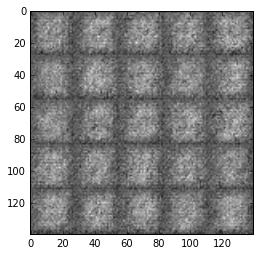

Epoch 1/2	 Discirminator Loss 1.3663	 Generator Loss 0.9222
Epoch 1/2	 Discirminator Loss 1.3051	 Generator Loss 0.9365
Epoch 1/2	 Discirminator Loss 1.2578	 Generator Loss 0.9876
Epoch 1/2	 Discirminator Loss 1.2394	 Generator Loss 1.0146
Epoch 1/2	 Discirminator Loss 1.2025	 Generator Loss 1.0333
Epoch 1/2	 Discirminator Loss 1.2127	 Generator Loss 0.9954
Epoch 1/2	 Discirminator Loss 1.2392	 Generator Loss 0.9770
Epoch 1/2	 Discirminator Loss 1.2415	 Generator Loss 0.9816
Epoch 1/2	 Discirminator Loss 1.2395	 Generator Loss 0.9956
Epoch 1/2	 Discirminator Loss 1.1852	 Generator Loss 0.9757


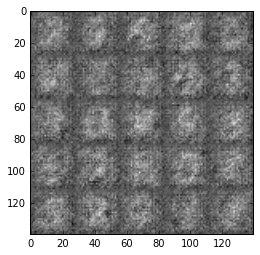

Epoch 1/2	 Discirminator Loss 1.2439	 Generator Loss 0.9472
Epoch 1/2	 Discirminator Loss 1.1952	 Generator Loss 0.9938
Epoch 1/2	 Discirminator Loss 1.1983	 Generator Loss 0.9407
Epoch 1/2	 Discirminator Loss 1.2458	 Generator Loss 0.9207
Epoch 1/2	 Discirminator Loss 1.2319	 Generator Loss 0.9241
Epoch 1/2	 Discirminator Loss 1.2297	 Generator Loss 0.9577


In [25]:
batch_size = 256
z_dim = 100
learning_rate = 0.000005
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1	 Discirminator Loss 1.8465	 Generator Loss 0.4117
Epoch 0/1	 Discirminator Loss 1.8401	 Generator Loss 0.3952
Epoch 0/1	 Discirminator Loss 1.6894	 Generator Loss 0.4585
Epoch 0/1	 Discirminator Loss 1.6739	 Generator Loss 0.4683
Epoch 0/1	 Discirminator Loss 1.6787	 Generator Loss 0.4826
Epoch 0/1	 Discirminator Loss 1.6770	 Generator Loss 0.4814
Epoch 0/1	 Discirminator Loss 1.5935	 Generator Loss 0.5412
Epoch 0/1	 Discirminator Loss 1.5787	 Generator Loss 0.5722
Epoch 0/1	 Discirminator Loss 1.5366	 Generator Loss 0.6010
Epoch 0/1	 Discirminator Loss 1.5133	 Generator Loss 0.6258


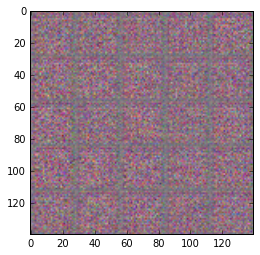

Epoch 0/1	 Discirminator Loss 1.5436	 Generator Loss 0.6239
Epoch 0/1	 Discirminator Loss 1.4801	 Generator Loss 0.6611
Epoch 0/1	 Discirminator Loss 1.4450	 Generator Loss 0.6761
Epoch 0/1	 Discirminator Loss 1.4239	 Generator Loss 0.7159
Epoch 0/1	 Discirminator Loss 1.3352	 Generator Loss 0.7671
Epoch 0/1	 Discirminator Loss 1.4073	 Generator Loss 0.8087
Epoch 0/1	 Discirminator Loss 1.2789	 Generator Loss 0.8321
Epoch 0/1	 Discirminator Loss 1.2434	 Generator Loss 0.8607
Epoch 0/1	 Discirminator Loss 1.2995	 Generator Loss 0.9084
Epoch 0/1	 Discirminator Loss 1.2474	 Generator Loss 0.9434


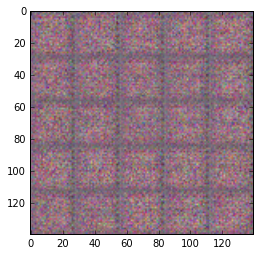

Epoch 0/1	 Discirminator Loss 1.2082	 Generator Loss 0.9693
Epoch 0/1	 Discirminator Loss 1.2495	 Generator Loss 0.9328
Epoch 0/1	 Discirminator Loss 1.1690	 Generator Loss 0.9899
Epoch 0/1	 Discirminator Loss 1.2685	 Generator Loss 1.0262
Epoch 0/1	 Discirminator Loss 1.1948	 Generator Loss 1.0011
Epoch 0/1	 Discirminator Loss 1.2122	 Generator Loss 1.0136
Epoch 0/1	 Discirminator Loss 1.1522	 Generator Loss 1.0655
Epoch 0/1	 Discirminator Loss 1.0970	 Generator Loss 1.1174
Epoch 0/1	 Discirminator Loss 1.0535	 Generator Loss 1.1621
Epoch 0/1	 Discirminator Loss 1.0492	 Generator Loss 1.2017


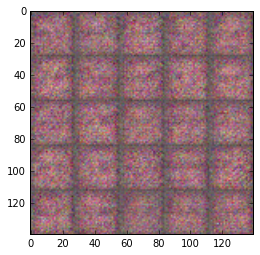

Epoch 0/1	 Discirminator Loss 1.0284	 Generator Loss 1.2377
Epoch 0/1	 Discirminator Loss 0.9894	 Generator Loss 1.2427
Epoch 0/1	 Discirminator Loss 0.9924	 Generator Loss 1.2737
Epoch 0/1	 Discirminator Loss 1.0005	 Generator Loss 1.2344
Epoch 0/1	 Discirminator Loss 1.0344	 Generator Loss 1.2606
Epoch 0/1	 Discirminator Loss 0.9820	 Generator Loss 1.2979
Epoch 0/1	 Discirminator Loss 0.9711	 Generator Loss 1.3011
Epoch 0/1	 Discirminator Loss 0.9790	 Generator Loss 1.3392
Epoch 0/1	 Discirminator Loss 0.9981	 Generator Loss 1.3132
Epoch 0/1	 Discirminator Loss 0.9732	 Generator Loss 1.3885


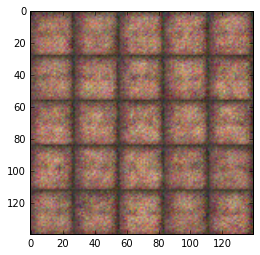

Epoch 0/1	 Discirminator Loss 0.9480	 Generator Loss 1.3754
Epoch 0/1	 Discirminator Loss 0.9617	 Generator Loss 1.4081
Epoch 0/1	 Discirminator Loss 0.9768	 Generator Loss 1.3768
Epoch 0/1	 Discirminator Loss 0.9507	 Generator Loss 1.3739
Epoch 0/1	 Discirminator Loss 0.9763	 Generator Loss 1.3524
Epoch 0/1	 Discirminator Loss 1.0061	 Generator Loss 1.3147
Epoch 0/1	 Discirminator Loss 1.0207	 Generator Loss 1.3137
Epoch 0/1	 Discirminator Loss 1.0463	 Generator Loss 1.3049
Epoch 0/1	 Discirminator Loss 1.0208	 Generator Loss 1.2395
Epoch 0/1	 Discirminator Loss 1.0523	 Generator Loss 1.2625


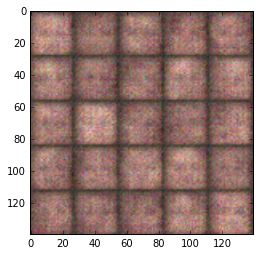

Epoch 0/1	 Discirminator Loss 1.1123	 Generator Loss 1.1626
Epoch 0/1	 Discirminator Loss 1.0660	 Generator Loss 1.2380
Epoch 0/1	 Discirminator Loss 1.1173	 Generator Loss 1.1425
Epoch 0/1	 Discirminator Loss 1.0358	 Generator Loss 1.2426
Epoch 0/1	 Discirminator Loss 1.0056	 Generator Loss 1.2723
Epoch 0/1	 Discirminator Loss 0.9211	 Generator Loss 1.2862
Epoch 0/1	 Discirminator Loss 1.0232	 Generator Loss 1.2161
Epoch 0/1	 Discirminator Loss 0.9639	 Generator Loss 1.2293
Epoch 0/1	 Discirminator Loss 1.0533	 Generator Loss 1.2219
Epoch 0/1	 Discirminator Loss 0.9673	 Generator Loss 1.3017


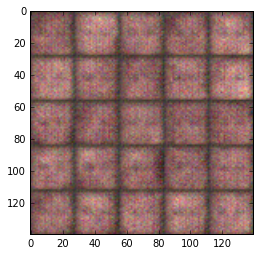

Epoch 0/1	 Discirminator Loss 1.0237	 Generator Loss 1.2505
Epoch 0/1	 Discirminator Loss 1.0538	 Generator Loss 1.2313
Epoch 0/1	 Discirminator Loss 1.0084	 Generator Loss 1.2367
Epoch 0/1	 Discirminator Loss 0.9616	 Generator Loss 1.2739
Epoch 0/1	 Discirminator Loss 1.0288	 Generator Loss 1.2831
Epoch 0/1	 Discirminator Loss 1.0248	 Generator Loss 1.2514
Epoch 0/1	 Discirminator Loss 1.0066	 Generator Loss 1.2567
Epoch 0/1	 Discirminator Loss 1.0029	 Generator Loss 1.3031
Epoch 0/1	 Discirminator Loss 1.0098	 Generator Loss 1.2575
Epoch 0/1	 Discirminator Loss 1.0146	 Generator Loss 1.2489


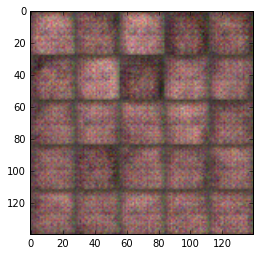

Epoch 0/1	 Discirminator Loss 1.0340	 Generator Loss 1.3082
Epoch 0/1	 Discirminator Loss 0.9809	 Generator Loss 1.2947
Epoch 0/1	 Discirminator Loss 0.9354	 Generator Loss 1.3534
Epoch 0/1	 Discirminator Loss 1.0326	 Generator Loss 1.2674
Epoch 0/1	 Discirminator Loss 0.9965	 Generator Loss 1.2462
Epoch 0/1	 Discirminator Loss 1.0087	 Generator Loss 1.1954
Epoch 0/1	 Discirminator Loss 0.9901	 Generator Loss 1.2504
Epoch 0/1	 Discirminator Loss 0.9898	 Generator Loss 1.2569
Epoch 0/1	 Discirminator Loss 0.9838	 Generator Loss 1.2556


In [27]:
batch_size = 256
z_dim = 100
learning_rate = 0.000005
beta1 = 0.5
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.